# Analysis of human and model behavior across physical domains

**The purpose of this notebook is to:** 
* Apply preprocessing to human behavioral data
* Visualize distribution and compute summary statistics over **human** physical judgments
* Visualize distribution and compute summary statistics over **model** physical judgments
* Conduct human-model comparisons
* Output CSV that can be re-loaded into R notebook for statistical modeling & fancy visualizations

**This notebook depends on:**
* Running `./generate_dataframes.py` (INTERNAL USE ONLY)
* Running `./upload_results.py` (INTERNAL USE ONLY)
* Running `./download_results.py` (PUBLIC USE)

## setup

#### Load packages

In [60]:
import os
import sys
import urllib, io

sys.path.append('./analysis_helpers')
from importlib import reload
from analysis_helpers import *

import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

from tqdm.notebook import tqdm

import  matplotlib
from matplotlib import pylab, mlab, pyplot
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.style.use('seaborn-white')

import seaborn as sns

%matplotlib inline
import scipy.stats
import random

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

#### options

In [61]:
# display all columns
pd.set_option('display.max_columns', None)

# seaborn plotting themes
sns.set_context('talk')
sns.set_style("whitegrid")

#### set up paths and directories

In [48]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
## add helpers to python path
if os.path.join(analysis_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(analysis_dir,'utils'))   

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir]]

### load in data

In [49]:
from experiment_meta import *
HEM = pd.DataFrame(NEURIPS2021_EXPS) # HEM = "human experiment metadata"
HEM

,study,bucket_name,stim_version,iterationName
0,dominoes_pilot,human-physics-benchmarking-dominoes-pilot,production_1,production_1_testing
1,collision_pilot,human-physics-benchmarking-collision-pilot,production_2,production_2_testing
2,towers_pilot,human-physics-benchmarking-towers-pilot,production_2,production_2_testing
3,linking_pilot,human-physics-benchmarking-linking-pilot,production_2,production_2_testing
4,containment_pilot,human-physics-benchmarking-containment-pilot,production_2,production_2_testing
5,rollingsliding_pilot,human-physics-benchmarking-rollingsliding-pilot,production_2,production_2_testing
6,drop_pilot,human-physics-benchmarking-drop-pilot,production_2,production_2_testing
7,clothiness_pilot,human-physics-benchmarking-clothiness-pilot,production_2,production_2_testing


In [50]:
## get paths to all human response data
data_paths = [os.path.join(csv_dir,'humans',i) for i in os.listdir(os.path.join(csv_dir,'humans'))]
resp_paths = [i for i in data_paths if i.split('/')[-1].split('-')[0]=='human_responses']
assert len(resp_paths)==8

In [51]:
## load in example dataframe
exp_ind = 0
d = pd.read_csv(resp_paths[exp_ind])
scenarioName = resp_paths[exp_ind].split('/')[-1].split('-')[1].split('_')[0]

## some utility vars
colnames_with_variable_entries = [col for col in sorted(d.columns) if len(np.unique(d[col]))>1]
# colnames = ['gameID','trialNum','prolificIDAnon','stim_ID','response','target_hit_zone_label','correct','choices','rt']
colnames = ['gameID','trialNum','stim_ID','response','target_hit_zone_label','correct','choices','rt']

## subset dataframe by colnames of interest
_D = d[colnames]
_D = _D.assign(scenarioName = scenarioName)

## preprocess RTs (subtract 2500ms presentation time, log transform)
_D = _D.assign(RT = _D['rt'] - 2500) 
_D = _D.assign(logRT = np.log(_D['RT']))
_D = _D.drop(columns=['rt'],axis=1)

### Data exclusion criteria (from `preregistration_neurips2021.md`)

 Data from an entire experimental session will be excluded if the responses:
 * contain a sequence with unusually long streak, defined as occurring less than 2.5% of the time under random responding
 * contain a sequence of at least 24 trials alternating "yes" and "no" responses
 * are correct for fewer than 4 out of 10 familiarization trials (i.e., 30% correct or lower)
 * the mean accuracy for that participant is below 3 standard deviations below the median accuracy across all participants for that scenario
 * the mean log-transformed response time for that participant is 3 standard deviations above the median log-transformed response time across all participants for that scenario
 
Excluded sessions will be flagged. Flagged sessions will not be included in the main analyses. We will also conduct our planned analyses with the flagged sessions included to investigate the extent to which the outcomes of the main analyses change when these sessions are included. Specifically, we will fit a statistical model to all sessions and estimate the effect of a session being flagged on accuracy. 

In [52]:
from analysis_helpers import *
D = apply_exclusion_criteria(_D)

97.5th percentile for streak length is 12.0.
There are 3 flagged IDs so far due to long streaks.
There are 0 flagged IDs so far due to alternating sequences.
TODO: Still need to flag familiarization trial failures!!!!
There are 2 flagged IDs so far due to low accuracy.
There are 1 flagged IDs so far due to high RTs.
There are a total of 6 flagged IDs.
There are a total of 94 valid and complete sessions for collision.


## Visualize distribution and compute summary statistics over human physical judgments



### Human accuracy across participants for each stimulus
We will analyze accuracy for each stimulus by computing the proportion of correct responses across all participants who viewed that stimulus. 



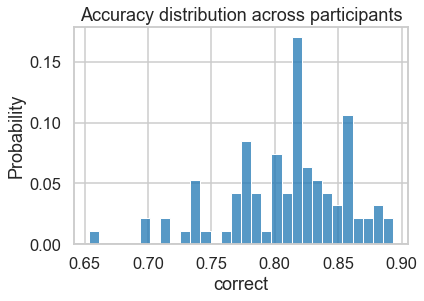

In [65]:
Dacc = D.groupby('gameID').agg({'correct':np.mean})
h = sns.histplot(data=Dacc, x='correct', bins=30, stat='probability')
t = plt.title('Accuracy distribution across participants')

In [66]:
def bootstrap_mean(D, col = 'correct', nIter=1000):
    bootmean = []
    for currIter in np.arange(nIter):
        bootD = D.sample(n=len(D),random_state=currIter, replace=True)            
        bootmean.append(np.mean(bootD[col].values))
    return bootmean

In [67]:
bootmeans = bootstrap_mean(Dacc, col='correct', nIter=1000)
lb = np.percentile(bootmeans,2.5)
ub = np.percentile(bootmeans,97.5)
print('The observed mean accuracy for {} is {}.'.format(scenarioName, np.round(Dacc['correct'].mean(),3)))
print('95% CI: [{},{}].'.format(lb.round(3),ub.round(3)))

The observed mean accuracy for collision is 0.809.
95% CI: [0.799,0.818].


### Human accuracy across stimuli for each participant
We will analyze accuracy for each participant by computing the proportion of correct responses across all stimuli. 



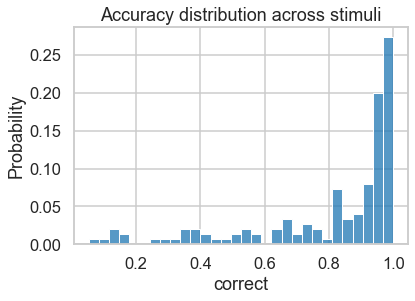

In [69]:
Dacc = D.groupby('stim_ID').agg({'correct':np.mean})
h = sns.histplot(data=Dacc, x='correct', bins=30, stat='probability')
t = plt.title('Accuracy distribution across stimuli')

### Human-human consistency for each stimulus
We will estimate human-human consistency for each stimulus by computing the proportion of responses that match the modal response for that stimulus (whether that modal response is correct or incorrect).



### Human-human consistency across stimuli (within scenario)
We will analyze human-human consistency by computing the mean correlation between (binary) response vectors produced by each human participant across all stimuli within each scenario. 



### Human accuracy as a function of stimulus attributes
We will conduct exploratory analyses of human accuracy as a function of various scenario-specific stimulus attributes that varied across trials. We will examine those stimulus attributes that varied across stimuli within each scenario and explore the relationship between each individual attribute and human accuracy, as well as beetween linear combinations of them and human accuracy. 



### Human accuracy by scenario
We will fit human responses across all scenarios with a mixed-effects logistic regression model, including scenario as a fixed effect and participants and individual stimuli as random effects.



### Other exploratory human behavioral analyses
* We will explore the relation of demographic variables on the performance of participants: how does age, gender, educational status and the the result of a one-trial spatial reasoning task relate to the overall accuracy of a subject?
* We will additionally explore any potential left/right or yes/no response biases. 


## Visualize distribution of model physical judgments, by domain

## Compute summary statistics over model physical judgments, by domain

## Conduct human-model comparisons
We will compare human and model behavior in two ways: **absolute performance** and **response pattern.**

#### **Absolute Performance** 
We will compare the accuracy of each model to the mean accuracy of humans, for each scenario. 
To do this, we will first compute estimates of mean human accuracy for each scenario and construct 95% confidence intervals for each of these estimates. 
These confidence intervals will be constructed by bootstrapping: specifically, for an experiment with N participants, we will resample N participants with replacement and compute the proportion correct for that bootstrapped sample. We will take repeat this resampling procedure 1000 times to generate a sampling distribution for the mean proportion correct. The 2.5th and 97.5th percentile will be extracted from this sampling distribution to provide the lower and upper bounds of the 95% confidence interval.

For each model, we will then compare their proportion correct (a point estimate) to the human confidence interval. 

#### **Response Pattern**
We will compare the pattern of predictions generated by each model to the pattern of predictions generated by humans. 

We will do this by using two standard inter-rater reliability metrics:
##### **Correlation**
For each pair of human participants, we will compute the correlation between their (binary) response vectors, yielding a distribution of pairwise human-human correlations. 
For each model, we will compute the correlation between its response vector and every human participant, as well as every other model. 
A model's response pattern will be considered more similar to humans' insofar as the mean model-human correlation (across humans) lies closer to the mean human-human correlation (for all pairs of humans).

##### **Cohen's kappa**